         date   meantemp   humidity  wind_speed  meanpressure
0  2017-01-01  15.913043  85.869565    2.743478     59.000000
1  2017-01-02  18.500000  77.222222    2.894444   1018.277778
2  2017-01-03  17.111111  81.888889    4.016667   1018.333333
3  2017-01-04  18.700000  70.050000    4.545000   1015.700000
4  2017-01-05  18.388889  74.944444    3.300000   1014.333333
Epoch 1/50
3/3 [==============================] - 8s 1s/step - loss: 0.4109 - val_loss: 0.4380
Epoch 2/50
3/3 [==============================] - 0s 58ms/step - loss: 0.3237 - val_loss: 0.3657
Epoch 3/50
3/3 [==============================] - 0s 54ms/step - loss: 0.2417 - val_loss: 0.2873
Epoch 4/50
3/3 [==============================] - 0s 52ms/step - loss: 0.1641 - val_loss: 0.2106
Epoch 5/50
3/3 [==============================] - 0s 59ms/step - loss: 0.0813 - val_loss: 0.1796
Epoch 6/50
3/3 [==============================] - 0s 69ms/step - loss: 0.0520 - val_loss: 0.1766
Epoch 7/50
3/3 [==============================] 

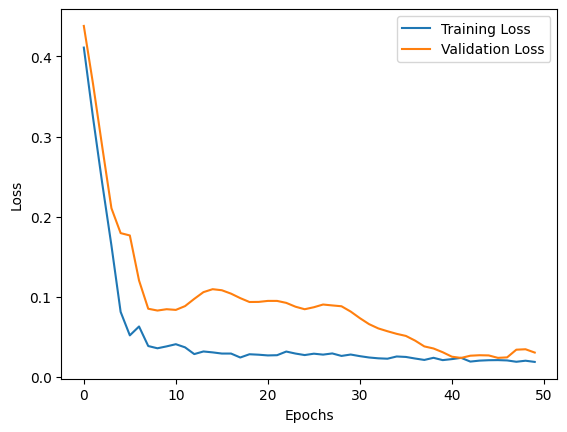

1/1 [==============================] - 1s 1s/step
Mean Absolute Error (MAE): 10.674385568518483
Root Mean Squared Error (RMSE): 15.854506698453793


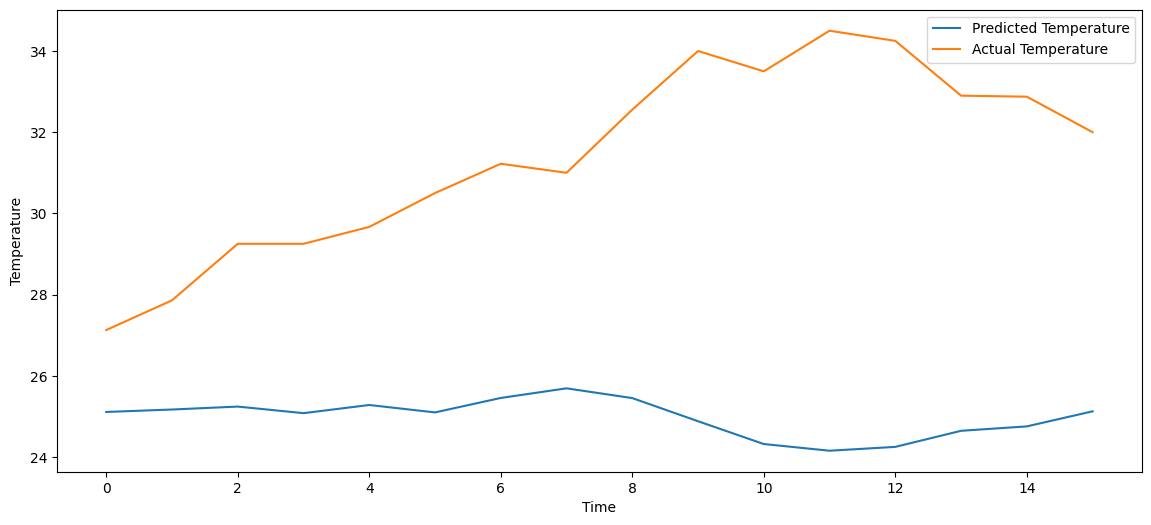

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

# Load the dataset
df = pd.read_csv('DailyDelhiClimateTest.csv')

# Display the first few rows of the dataset
print(df.head())

# Preprocessing
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort the dataframe by date
df.sort_values('date', inplace=True)

# Extract numerical features
features = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
data = df[features].values

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split the data into train and test sets
train_size = int(0.8 * len(data_scaled))
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Define function to create input sequences and labels
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7  # one week's worth of data

# Create sequences and labels for training set
X_train, y_train = create_sequences(train_data, seq_length)

# Create sequences and labels for test set
X_test, y_test = create_sequences(test_data, seq_length)

# Model Architecture
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=4)
])

# Compile the model
model.compile(optimizer=Adam(), loss=MeanSquaredError())

# Model Training
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Model Evaluation
loss = model.evaluate(X_test, y_test)

# Visualize training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Predictions
predictions = model.predict(X_test)

# Inverse transform predictions and actual values
predictions_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate MAE and RMSE
mae = np.mean(np.abs(predictions_inv - y_test_inv))
rmse = np.sqrt(np.mean(np.square(predictions_inv - y_test_inv)))

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

# Visualize predictions
plt.figure(figsize=(14, 6))
plt.plot(predictions_inv[:, 0], label='Predicted Temperature')
plt.plot(y_test_inv[:, 0], label='Actual Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()
